Synchronize DLC results with xr_session

In [1]:
from trialexp.process.deeplabcut import utils as dlc_utils
import pandas as pd
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import Video
import seaborn as sns

In [2]:
fn = '06-14-23_14-40-49.000_TT002_Rig_3_Side_recode'
session_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-06-14-144112/'
videofile = session_path +f'video/{fn}.mp4'

# Load DLC results

In [3]:
dftip = pd.read_pickle('dftip.pkl')
dfwrist = pd.read_pickle('dfwrist.pkl')

In [4]:
ts = dlc_utils.extract_video_timestamp(videofile)


In [5]:
dfwrist['time'] = ts
dftip['time'] = ts

In [6]:
dfwrist = dfwrist.set_index('time')
dftip = dftip.set_index('time')

## Synchronize with the xr_session

In [7]:
xr_session = xr.open_dataset(session_path+'/processed/xr_session.nc')

In [8]:
xr_session

<xarray.Dataset>
Dimensions:                           (session_id: 1, trial_nb: 237,
                                       time: 176428, event_time: 500)
Coordinates:
  * session_id                        (session_id) object 'TT002-2023-06-14-1...
  * trial_nb                          (trial_nb) int64 1 2 3 4 ... 235 236 237
  * time                              (time) float64 7.608e+03 ... 1.772e+06
  * event_time                        (event_time) int64 -1995 -1985 ... 2995
Data variables: (12/30)
    uid                               (session_id, trial_nb) object ...
    trigger                           (session_id, trial_nb) object ...
    valid                             (session_id, trial_nb) bool ...
    break_after_abort                 (session_id, trial_nb) bool ...
    US_end_timer                      (session_id, trial_nb) bool ...
    water_on                          (session_id, trial_nb) bool ...
    ...                                ...
    zscored_df_over_f                 (session_id, time) float64 ...
    trial                             (session_id, time) float64 ...
    hold_for_water_zscored_df_over_f  (session_id, trial_nb, event_time) float64 ...
    first_bar_off_zscored_df_over_f   (session_id, trial_nb, event_time) float64 ...
    first_spout_zscored_df_over_f     (session_id, trial_nb, event_time) float64 ...
    last_bar_off_zscored_df_over_f    (session_id, trial_nb, event_time) float64 ...
Attributes: (12/25)
    pulse_inds_1:         []
    pulse_inds_2:         [  24540   33979   42180   50527   56813   61995   ...
    pulse_times_1:        []
    pulse_times_2:        [  24540.   33979.   42180.   50527.   56813.   619...
    subject_ID:           TT002
    date_time:            2023-06-14T14:40:47
    ...                   ...
    Start date:           2023/06/14 14:41:12
    session_id:           TT002-2023-06-14-144112
    trial_window:         [-2000.  3000.]
    conditions:           ['break_after_abort', 'US_end_timer', 'water_on', '...
    triggers:             hold_for_water
    events_to_process:    ['bar', 'bar_off', 'spout', 'US_end_timer']

In [9]:
xr_session.time

<xarray.DataArray 'time' (time: 176428)>
array([   7608.5,    7618.5,    7628.5, ..., 1771847.5, 1771857.5, 1771867.5])
Coordinates:
  * time     (time) float64 7.608e+03 7.618e+03 ... 1.772e+06 1.772e+06

In [10]:
xr_dlc = xr.DataArray([dfwrist,dftip], dims=('marker','time','coords'),
                 coords={'marker':['wrist','tip'],
                         'time':dfwrist.index,
                         'coords':['x','y','likelihood']
                 })

In [11]:
# resample to the xr_session time
xr_dlc = xr_dlc.interp(time=xr_session.time)

In [12]:
xr_dlc.loc['wrist',:,'x']

<xarray.DataArray (time: 176428)>
array([866.0192364 , 866.03339214, 866.07619028, ..., 861.98608114,
       857.72235441, 855.94167446])
Coordinates:
    marker   <U5 'wrist'
    coords   <U10 'x'
  * time     (time) float64 7.608e+03 7.618e+03 ... 1.772e+06 1.772e+06

In [13]:
xr_session['dlc_markers'] = xr_dlc

In [14]:
xr_session

<xarray.Dataset>
Dimensions:                           (session_id: 1, trial_nb: 237,
                                       time: 176428, event_time: 500,
                                       marker: 2, coords: 3)
Coordinates:
  * session_id                        (session_id) object 'TT002-2023-06-14-1...
  * trial_nb                          (trial_nb) int64 1 2 3 4 ... 235 236 237
  * time                              (time) float64 7.608e+03 ... 1.772e+06
  * event_time                        (event_time) int64 -1995 -1985 ... 2995
  * marker                            (marker) <U5 'wrist' 'tip'
  * coords                            (coords) <U10 'x' 'y' 'likelihood'
Data variables: (12/31)
    uid                               (session_id, trial_nb) object ...
    trigger                           (session_id, trial_nb) object ...
    valid                             (session_id, trial_nb) bool ...
    break_after_abort                 (session_id, trial_nb) bool ...
    US_end_timer                      (session_id, trial_nb) bool ...
    water_on                          (session_id, trial_nb) bool ...
    ...                                ...
    trial                             (session_id, time) float64 ...
    hold_for_water_zscored_df_over_f  (session_id, trial_nb, event_time) float64 ...
    first_bar_off_zscored_df_over_f   (session_id, trial_nb, event_time) float64 ...
    first_spout_zscored_df_over_f     (session_id, trial_nb, event_time) float64 ...
    last_bar_off_zscored_df_over_f    (session_id, trial_nb, event_time) float64 ...
    dlc_markers                       (marker, time, coords) float64 866.0 .....
Attributes: (12/25)
    pulse_inds_1:         []
    pulse_inds_2:         [  24540   33979   42180   50527   56813   61995   ...
    pulse_times_1:        []
    pulse_times_2:        [  24540.   33979.   42180.   50527.   56813.   619...
    subject_ID:           TT002
    date_time:            2023-06-14T14:40:47
    ...                   ...
    Start date:           2023/06/14 14:41:12
    session_id:           TT002-2023-06-14-144112
    trial_window:         [-2000.  3000.]
    conditions:           ['break_after_abort', 'US_end_timer', 'water_on', '...
    triggers:             hold_for_water
    events_to_process:    ['bar', 'bar_off', 'spout', 'US_end_timer']

In [15]:
wrist_loc = xr_session['dlc_markers'].loc['wrist',:,['x','y']]
tip_loc = xr_session['dlc_markers'].loc['tip',:,['x','y']]

## Plot event with DLC markers

In [16]:
df_pycontrol = pd.read_pickle(session_path +'processed/df_pycontrol.pkl')
df_spout = df_pycontrol[df_pycontrol.name =='spout']
df_baroff = df_pycontrol[df_pycontrol.name =='bar_off']
df_hold = df_pycontrol[df_pycontrol.name =='hold_for_water']

max_time = 1000*100
df_spout = df_spout[df_spout.time<max_time]
df_baroff = df_baroff[df_baroff.time<max_time]
df_hold = df_hold[df_hold.time<max_time]

In [17]:
photo_signal = xr_session.zscored_df_over_f.data[0]

In [18]:
wrist_segment = wrist_loc
signal_time = wrist_segment.time/1000
data = wrist_segment.data
speed = np.sqrt(np.sum(np.diff(data,axis=0, prepend=[data[0,:]])**2,axis=1))

In [19]:
marker_signal = dlc_utils.get_marker_signal(wrist_loc)
events2plot = df_pycontrol[df_pycontrol.name.isin(['hold_for_water', 'spout','bar_off'])]


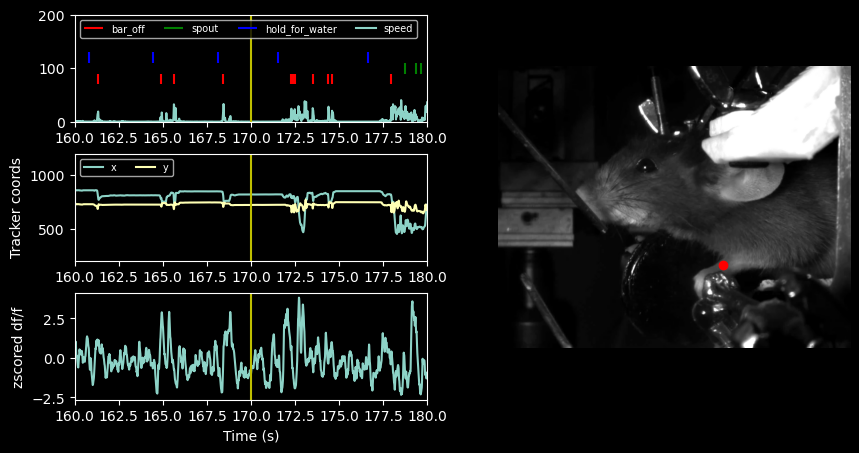

In [28]:
def get_marker_signal(marker_loc):
    signal_time = marker_loc.time.data/1000
    coords = wrist_segment.data
    speed = np.sqrt(np.sum(np.diff(coords,axis=0, prepend=[coords[0,:]])**2,axis=1))
    return (signal_time, coords, speed)

def plot_event_video(t, starting_time, time_span, events2plot, clip, marker_signal):

    # events2plot should contains all the events that needs to be plotted
    
    x_start_time = starting_time + t//time_span*time_span
    x_end_time = x_start_time+time_span

    ax1 = plt.subplot2grid((3, 2), (0, 0))
    ax2 = plt.subplot2grid((3, 2), (1, 0), sharex=ax1)
    ax3 = plt.subplot2grid((3, 2), (2, 0), sharex=ax1)
    ax4 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)

    plot_axes = [ax1,ax2,ax3]
    
    
    ## Event
    evt_colours =['r','g','b','w']
    for i, event in enumerate(events2plot.name.unique()):
        evt_time = events2plot[events2plot.name==event].time/1000
        evt_time = evt_time[(evt_time>x_start_time) & (evt_time<=x_end_time)]
        ax1.eventplot(evt_time, lineoffsets=80+20*i, linelengths=20,label=event, color=evt_colours[i])
    
    
    ## Speed data
    (signal_time, coords, speed) = marker_signal
    
    ax1.plot(signal_time, speed, label='speed')
    ax1.legend(loc='upper left', prop = { "size": 7 }, ncol=4)
    ax1.set_ylim([0, 200])
    
    
    ## Marker coordinates
    idx2plot = (signal_time > x_start_time) & (signal_time<x_start_time+time_span)
    ax2.plot(signal_time[idx2plot], coords[idx2plot, 0], label='x')
    ax2.plot(signal_time[idx2plot], coords[idx2plot,1], label='y')
    ax2.legend(loc='upper left', prop = { "size": 7 }, ncol=4)
    ax2.set_ylabel('Tracker coords')
    ax2.set_ylim([200, 1200])

    
    ## Photometry signal
    ax3.plot(signal_time[idx2plot], photo_signal[idx2plot])
    ax3.set_ylabel('zscored df/f')

    ax1.set(xlim=(x_start_time,x_start_time+time_span))
    
    #plot the line for the curren time
    for ax in plot_axes:
        ax.axvline(starting_time+t,color='y')
    ax3.set_xlabel('Time (s)')
    
    ## Video
    ax4.imshow(clip.get_frame(starting_time+t))
    ax4.axis('off')
    
    ## Plot the marker location on the video too
    idx = np.argmin(abs(signal_time - (starting_time+t))) # use time to find the correct index to plot
    ax4.plot(coords[idx,0], coords[idx,1], 'ro')
    
    plt.subplots_adjust(hspace=0.3)
                        

clip = VideoFileClip(videofile)
plt.figure(figsize=(10,5), dpi=100)
plt.style.use('dark_background')
plot_event_video(90, 80, 20, events2plot, clip, marker_signal);

Moviepy - Building video event_video_25.mp4.
Moviepy - Writing video event_video_25.mp4



Moviepy - Done !
Moviepy - video ready event_video_25.mp4


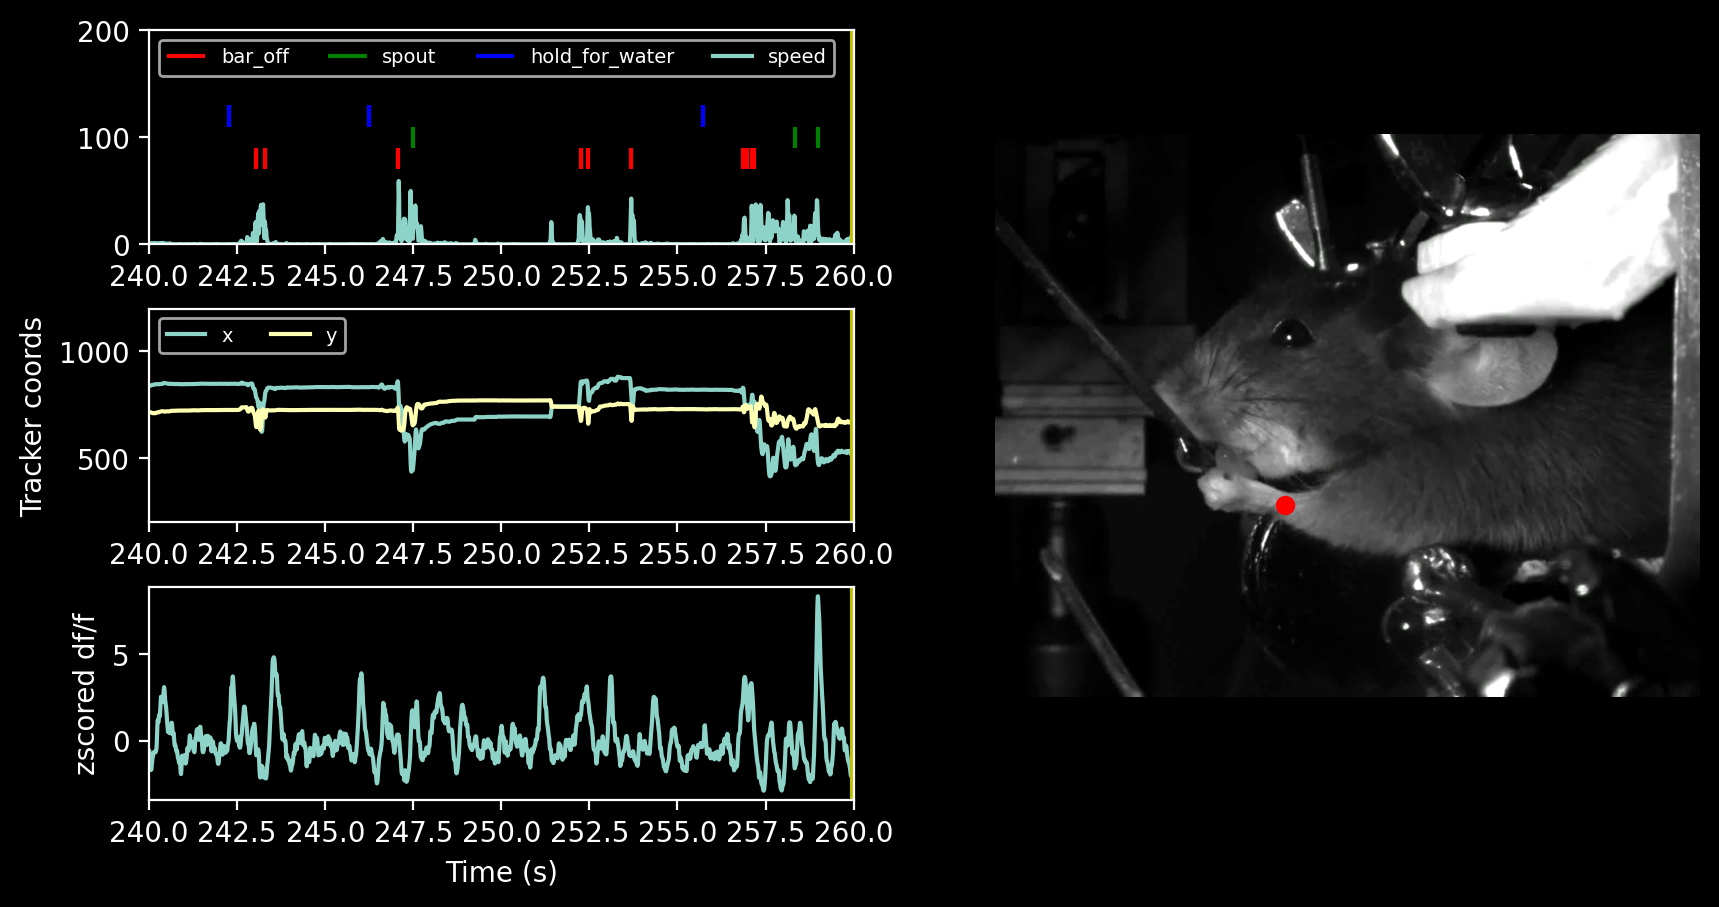

In [29]:
plt.figure(figsize=(10,5), dpi=200)

def make_frame(t):
    plot_event_video(t, 80, 20, events2plot, clip, marker_signal)
    return mplfig_to_npimage(plt.gcf())

animation_fps = 25
animation = VideoClip(make_frame, duration=180)
animation.write_videofile(f'event_video_{animation_fps}.mp4', fps=animation_fps, threads=10)
Video(f'event_video_{animation_fps}.mp4', width=1024)